# Improved PINN for 3D Time-Dependent Schrödinger

This notebook implements the suggested corrections:

- **Dirichlet boundary conditions** (ψ=0 on box faces)
- Increased **collocation** (domain), **initial-condition**, and **boundary-condition** sampling
- **Loss weights** for PDE, IC, BC
- **Adam** warm-up + **L-BFGS** fine-tuning
- **SIREN** (sinusoidal activations) network architecture


In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
torch.manual_seed(0)


In [2]:
# === SIREN Network Definition ===
class SineLayer(nn.Module):
    def __init__(self, in_f, out_f, omega_0=30.0):
        super().__init__()
        self.omega_0 = omega_0
        self.linear = nn.Linear(in_f, out_f)
        nn.init.uniform_(self.linear.weight, -1/ in_f, 1/ in_f)
        nn.init.zeros_(self.linear.bias)
    def forward(self, x):
        return torch.sin(self.omega_0 * self.linear(x))

class SirenNet(nn.Module):
    def __init__(self, layers, omega_0=30.0):
        super().__init__()
        self.net = []
        # First layer with different initialization
        self.net.append(SineLayer(layers[0], layers[1], omega_0))
        for i in range(1, len(layers)-2):
            self.net.append(SineLayer(layers[i], layers[i+1], omega_0))
        # Final linear layer
        self.net.append(nn.Linear(layers[-2], layers[-1]))
        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        return self.net(x)

# Instantiate a SIREN: inputs=4 -> hidden layers -> output=2
layers = [4, 128, 128, 128, 2]
model = SirenNet(layers)


In [3]:
# === PDE Residual ===
def schrodinger_residual(model, x, y, z, t, V_func, hbar=1.0, m=1.0):
    x = x.clone().detach().requires_grad_(True)
    y = y.clone().detach().requires_grad_(True)
    z = z.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)
    X = torch.cat([x, y, z, t], dim=1)
    psi = model(X)
    psi_r, psi_i = psi[:,0:1], psi[:,1:2]

    # time derivatives
    psi_r_t = autograd.grad(psi_r, t, torch.ones_like(psi_r), create_graph=True)[0]
    psi_i_t = autograd.grad(psi_i, t, torch.ones_like(psi_i), create_graph=True)[0]

    # spatial Laplacian
    def laplacian(u, coords):
        grad_u = autograd.grad(u, coords, torch.ones_like(u), create_graph=True)[0]
        return autograd.grad(grad_u, coords, torch.ones_like(grad_u), create_graph=True)[0]

    lap_r = laplacian(psi_r, x) + laplacian(psi_r, y) + laplacian(psi_r, z)
    lap_i = laplacian(psi_i, x) + laplacian(psi_i, y) + laplacian(psi_i, z)

    V = V_func(x, y, z)
    res_r = hbar * psi_i_t + (hbar**2/(2*m)) * lap_r - V * psi_r
    res_i = -hbar * psi_r_t + (hbar**2/(2*m)) * lap_i - V * psi_i
    return res_r, res_i


In [4]:
# === Sampling Functions ===
L, T = 1.0, 1.0  # Box size and final time

def sample_domain(N):
    x = torch.rand(N,1, requires_grad=True) * L
    y = torch.rand(N,1, requires_grad=True) * L
    z = torch.rand(N,1, requires_grad=True) * L
    t = torch.rand(N,1, requires_grad=True) * T
    return x, y, z, t

def sample_initial(N):
    x = torch.rand(N,1, requires_grad=True) * L
    y = torch.rand(N,1, requires_grad=True) * L
    z = torch.rand(N,1, requires_grad=True) * L
    t = torch.zeros_like(x, requires_grad=True)
    return x, y, z, t

def sample_boundary(N):
    # sample faces of the cube
    faces = []
    # x=0 or x=L
    for x0 in [0.0, L]:
        x = torch.full((N,1), x0, requires_grad=True)
        y = torch.rand(N,1, requires_grad=True) * L
        z = torch.rand(N,1, requires_grad=True) * L
        t = torch.rand(N,1, requires_grad=True) * T
        faces.append((x,y,z,t))
    # y=0 or y=L
    for y0 in [0.0, L]:
        x = torch.rand(N,1, requires_grad=True) * L
        y = torch.full((N,1), y0, requires_grad=True)
        z = torch.rand(N,1, requires_grad=True) * L
        t = torch.rand(N,1, requires_grad=True) * T
        faces.append((x,y,z,t))
    # z=0 or z=L
    for z0 in [0.0, L]:
        x = torch.rand(N,1, requires_grad=True) * L
        y = torch.rand(N,1, requires_grad=True) * L
        z = torch.full((N,1), z0, requires_grad=True)
        t = torch.rand(N,1, requires_grad=True) * T
        faces.append((x,y,z,t))
    # concatenate all faces
    xb, yb, zb, tb = torch.cat([f[0] for f in faces]), torch.cat([f[1] for f in faces]), torch.cat([f[2] for f in faces]), torch.cat([f[3] for f in faces])
    return xb, yb, zb, tb

# Potential & initial wavefunction
def V_func(x, y, z):
    return torch.zeros_like(x)

def psi_initial(x, y, z):
    return torch.exp(-((x-0.5*L)**2 + (y-0.5*L)**2 + (z-0.5*L)**2)/(0.1**2))


In [5]:
# === Training ===
# Loss weights
lambda_ic = 10.0
lambda_bc = 10.0

# Adam warm-up
adam_opt = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(1, 2001):
    # Domain residual
    x_r, y_r, z_r, t_r = sample_domain(10000)
    res_r, res_i = schrodinger_residual(model, x_r, y_r, z_r, t_r, V_func)
    loss_pde = (res_r**2 + res_i**2).mean()
    # Initial condition
    x_i, y_i, z_i, t_i = sample_initial(2000)
    psi0 = psi_initial(x_i, y_i, z_i)
    pred0 = model(torch.cat([x_i,y_i,z_i,t_i], dim=1))
    loss_ic = ((pred0[:,0:1] - psi0)**2 + (pred0[:,1:2])**2).mean()
    # Boundary condition
    x_b, y_b, z_b, t_b = sample_boundary(1000)
    pred_b = model(torch.cat([x_b,y_b,z_b,t_b], dim=1))
    loss_bc = (pred_b**2).mean()
    loss = loss_pde + lambda_ic*loss_ic + lambda_bc*loss_bc
    adam_opt.zero_grad()
    loss.backward()
    adam_opt.step()
    if epoch % 500 == 0:
        print(f"Adam Epoch {epoch}, Loss: {loss.item():.3e}")
# L-BFGS fine-tuning
lbfgs_opt = torch.optim.LBFGS(model.parameters(),
    max_iter=500,
    tolerance_grad=1e-8,
    tolerance_change=1e-8,
    history_size=50)

def lbfgs_closure():
    lbfgs_opt.zero_grad()
    x_r, y_r, z_r, t_r = sample_domain(10000)
    res_r, res_i = schrodinger_residual(model, x_r, y_r, z_r, t_r, V_func)
    loss_pde = (res_r**2 + res_i**2).mean()
    x_i, y_i, z_i, t_i = sample_initial(2000)
    psi0 = psi_initial(x_i, y_i, z_i)
    pred0 = model(torch.cat([x_i,y_i,z_i,t_i], dim=1))
    loss_ic = ((pred0[:,0:1] - psi0)**2 + (pred0[:,1:2])**2).mean()
    x_b, y_b, z_b, t_b = sample_boundary(1000)
    pred_b = model(torch.cat([x_b,y_b,z_b,t_b], dim=1))
    loss_bc = (pred_b**2).mean()
    loss = loss_pde + lambda_ic*loss_ic + lambda_bc*loss_bc
    loss.backward()
    return loss

lbfgs_opt.step(lbfgs_closure)
print("L-BFGS fine-tuning complete")


Adam Epoch 500, Loss: 4.743e-02
Adam Epoch 1000, Loss: 2.064e-02
Adam Epoch 1500, Loss: 2.700e-02
Adam Epoch 2000, Loss: 3.346e-02
L-BFGS fine-tuning complete


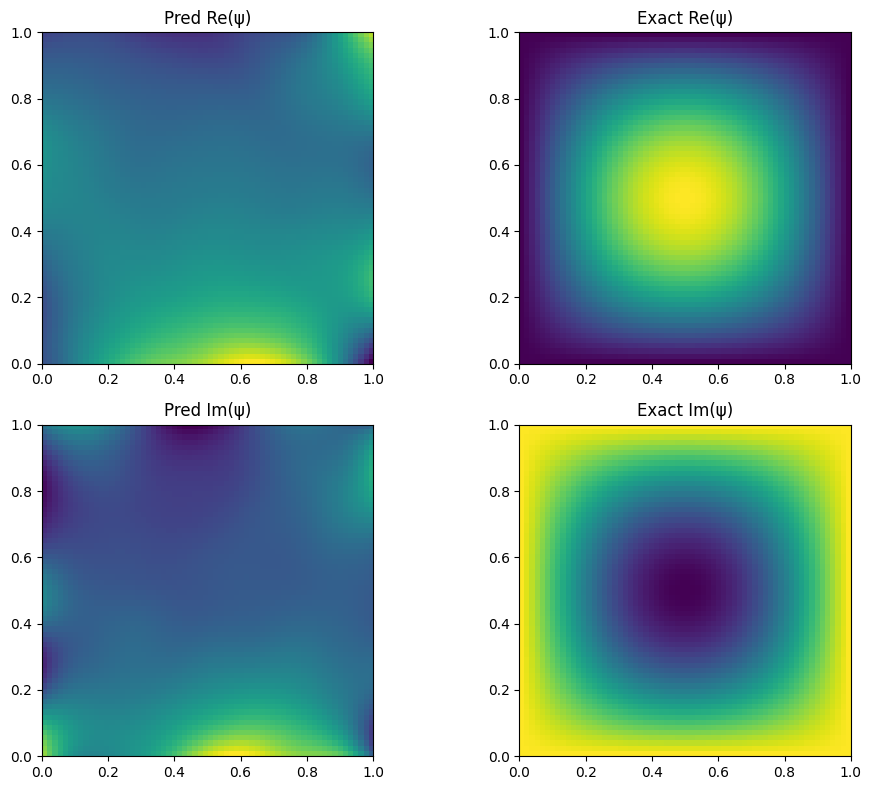

In [7]:
# === Exact Solution & Comparison ===
hbar = 1.0; m = 1.0
E111 = (3 * np.pi**2 * hbar**2)/(2*m * L**2)
def psi_exact(x, y, z, t):
    val = np.sin(np.pi*x/L)*np.sin(np.pi*y/L)*np.sin(np.pi*z/L)
    return val * np.exp(-1j * E111 * t / hbar)

# Evaluate at t=0.5, z=L/2
t0 = 0.5; z0 = L/2
n = 64
xs = np.linspace(0, L, n)
ys = np.linspace(0, L, n)
X, Y = np.meshgrid(xs, ys)
xf = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1)
yf = torch.tensor(Y.flatten(), dtype=torch.float32).unsqueeze(1)
zf = torch.full_like(xf, z0)
tf = torch.full_like(xf, t0)
with torch.no_grad():
    pred = model(torch.cat([xf, yf, zf, tf], dim=1)).numpy()
psi_r_pred = pred[:,0].reshape(n,n)
psi_i_pred = pred[:,1].reshape(n,n)

psi_ex = psi_exact(X, Y, z0, t0)
psi_r_ex = psi_ex.real
psi_i_ex = psi_ex.imag

# Plotting
fig, axs = plt.subplots(2,2, figsize=(10,8))
axs[0,0].imshow(psi_r_pred, extent=[0,L,0,L], origin='lower'); axs[0,0].set_title('Pred Re(ψ)')
axs[0,1].imshow(psi_r_ex, extent=[0,L,0,L], origin='lower'); axs[0,1].set_title('Exact Re(ψ)')
axs[1,0].imshow(psi_i_pred, extent=[0,L,0,L], origin='lower'); axs[1,0].set_title('Pred Im(ψ)')
axs[1,1].imshow(psi_i_ex, extent=[0,L,0,L], origin='lower'); axs[1,1].set_title('Exact Im(ψ)')
plt.tight_layout()
plt.show()
